In [1]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm
from collections import Counter
import matplotlib
import matplotlib.patheffects as PathEffects
from matplotlib import pylab, mlab, pyplot, colors
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re
from svgpathtools import parse_path
import svgpathtools

from PIL import Image
import base64
import sys

from svgpathtools import parse_path
from IPython.display import clear_output



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")



In [2]:
import svg_rendering_helpers as srh
if sys.version_info[0]>=3:
    from importlib import reload
reload(srh)

# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
features_dir= os.path.join(results_dir,'features')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)  

if not os.path.exists(features_dir):
    os.makedirs(features_dir)
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/kushin/Documents/GitHub/semantic_parts/analysis/analysis_helpers.pyc'>

In [3]:
## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

In [4]:
##Helpers



def subset_dataframe_by_condition(F,to_inspect='all',this_category='bird',this_object='bluejay'):
    '''
    input: F: dataframe (num_sketches x num_features)
           to_inspect: a string indicating whether to subset by ['object','category','all']
           this_category: IF to_inspect == 'category', then we define this to subset by that category only
           this_object: IF to_inspect == 'object', then we define this to subset by that object only
           
    returns: two feature matrices, c and f, corresponding to the close and far subsetted feature matrices
           
    '''
        
    F = F.sort_values(by=['category','target'])

    ## get context condition inds for subsetting dataframe
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'

    ## if we want to inspect particular category
    category_inds = F['category']==this_category

    ## if we want to inspect particular object
    obj_list = np.unique(F.target.values)
    obj_inds = F['target']==this_object  
    
    ## get names of columns that contain stroke-count & arclength information
    numstrokes_cols = [i for i in F.columns if i.split('_')[-1]=='numstrokes']
    arclength_cols = [i for i in F.columns if i.split('_')[-1]=='arclength']
    feat_cols = numstrokes_cols + arclength_cols
    
    if to_inspect == 'object':    
        ## extract particular row corresponding to this OBJECT in each condition
        f = F[(far_inds) & obj_inds][feat_cols].reset_index(drop=True)
        c = F[(close_inds) & obj_inds][feat_cols].reset_index(drop=True)
        obj_listf = F[(far_inds) & obj_inds]['target'].values
        obj_listc = F[(close_inds) & obj_inds]['target'].values
    elif to_inspect == 'category':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[(category_inds) & (far_inds)][feat_cols].reset_index(drop=True)
        c = F[(category_inds) & (close_inds)][feat_cols].reset_index(drop=True)
        obj_listf = F[(category_inds) & (far_inds)]['target'].values
        obj_listc = F[(category_inds) & (close_inds)]['target'].values
    elif to_inspect == 'all':
        ## extract particular rows corresponding to each condition
        f = F[far_inds][feat_cols].reset_index(drop=True)
        c = F[close_inds][feat_cols].reset_index(drop=True) 
        obj_listf = F[far_inds]['target'].values
        obj_listc = F[close_inds]['target'].values
        
    return c, f, obj_listc, obj_listf

In [5]:
#Load in annotated sketch dataset| subsetted for sketches with 3 annotations
D = pd.read_pickle(os.path.join(csv_dir, 'semantic_parts_annotated_data_pckl'))
D.shape

(58947, 28)

In [6]:
png= pd.read_csv(os.path.join(csv_dir, 'semantic_parts_annotated_pngstring.csv'))

In [7]:
png.shape

(864, 2)

In [8]:
## get the list of unique labels applied to sketches
unique_labels = np.unique(D.label.values)

## Removing Nones and obviously wrong super long lables
unique_labels = [i for i in unique_labels if i is not None]
unique_labels = [i for i in unique_labels if len(i)<900]

print 'we have {} unique labels'.format(len(unique_labels))

we have 24 unique labels


In [9]:
unique_cats= np.unique(D['category'])
##Create empty dictionary with categories as keys. We will use this to store part occurrence data for our categories
label_vect_dict = {unique_cats[0]:None,unique_cats[1]:None,unique_cats[2]:None,unique_cats[3]:None}

In [10]:
##Create vectors that contain the number of part instances in each sketch
num_annots=3

for category in unique_cats:
    DS= D[D['category']==category]
    unique_sketches_in_cat = np.unique(DS['sketch_id'])
    unique_labels_in_cat = np.unique(DS['label'])
    ## initialize matrix that has the correct dimensions
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)), dtype=int)
    unique_labels_in_cat= np.array(unique_labels_in_cat)
    for s,this_sketch in enumerate(unique_sketches_in_cat):
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSS = DS[DS['sketch_id']==this_sketch]
        annotation_ids = np.unique(DSS['annotation_id'].values)    
        for this_annotation in annotation_ids:
            DSA = DSS[DSS['annotation_id']==this_annotation]
            label_list = DSA.label.values
            for this_label in label_list:
                label_ind = unique_labels_in_cat==this_label
                label_vec[label_ind] += 1
            
        Label_Vec[s,:]=label_vec/num_annots
    label_vect_dict[category]= Label_Vec

In [11]:
valid_labels=[]
valid_labels_dict={}
for category in unique_cats:
    vect = label_vect_dict[category]
    thresh = 50
    #print 'These are the labels that appear at least {} times:'.format(thresh)
    #print unique_labels[np.sum(Label_Vec,0)>thresh]
    unique_labels_in_cat = np.unique(D[D['category']==category]['label'])
    plot_labels= unique_labels_in_cat[np.sum(vect,0)>thresh]
    valid_labels_dict[category]=plot_labels
    valid_labels.append(plot_labels)


    prop_labels=[]
    for part in plot_labels:
        DS=D[D['category']==category]
        prop_labels.append(DS[DS['label']==part]['annotation_id'].nunique()/DS['annotation_id'].nunique())
    
##flattening valid labels
valid_labels = [item for sublist in valid_labels for item in sublist]


In [12]:
#Creating a spline-level df where the modal label is set as the 'true' label for any given spline
spline_df= D.groupby('spline_id').agg(lambda x: Counter(x).most_common(1)[0][0])
spline_df.reset_index(level=0, inplace=True)

In [13]:
##Creating a stroke-level dataframe that takes the mode value of annotation for its children splines to set as its
##label value

from collections import Counter


from collections import OrderedDict
stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})


In [14]:
##Adding total arclength information to stroke dataframe

def calculate_arclength(svg):
    try:
        arclength= parse_path(svg).length()
    except ZeroDivisionError:
        print 'zero div error'
        arclength = 0
    return arclength
stroke_df['arc_length'] = stroke_df['svg'].apply(calculate_arclength)

### Lesioning sketches

In [15]:
stroke_df_png = stroke_df.merge(png,how='right', on='sketch_id')

In [17]:
test_sketch = stroke_df_png[stroke_df_png['sketch_id']=='0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_12']

In [18]:
parsed= test_sketch.svg

In [19]:
parsed= list(parsed)

In [20]:
for part in test_sketch.label.unique():
    test_sketch_l = test_sketch[test_sketch['label']!= part]
    parsed= list(test_sketch_l.svg)
    srh.render_svg(parsed,base_dir=sketch_dir,out_fname='without_{}.svg'.format(part))

In [85]:
svg_paths= srh.generate_svg_path_list(os.path.join(sketch_dir,'svg'))

In [87]:
srh.svg_to_png(svg_paths,base_dir=sketch_dir)

convert /Users/kushin/Documents/GitHub/semantic_parts/sketches/svg/3169-1a552a49-44e5-4a78-bed6-72a6aca82625_22_body_highlight.svg /Users/kushin/Documents/GitHub/semantic_parts/sketches/png/3169-1a552a49-44e5-4a78-bed6-72a6aca82625_22_body_highlight.png


In [16]:
unique_sketches = stroke_df_png.sketch_id.unique()

In [17]:
chair_parts= stroke_df_png[stroke_df_png['category']=='chair'].label.unique()

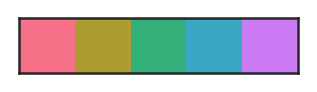

In [20]:
rgbcols = sns.color_palette("husl", len(chair_parts))
sns.palplot(rgbcols)

In [21]:
hexcols=[]
for this_col in rgbcols:
    hexcols.append(colors.to_hex(this_col))
hexcols= np.array(hexcols)

In [79]:
target_part= 'body'

In [25]:
chair_df = stroke_df_png[stroke_df_png['category']=='chair']

In [24]:

for this_chair in chair_df.sketch_id.unique():
    collist=[]
    chair_df_s = chair_df[chair_df['sketch_id']==this_chair]
    parts = chair_df_s.label
    for this_part in parts:
        if this_part == target_part:
            collist.append(hexcols[this_part==bird_parts][0])
        else:
            collist.append('#000000')
    svgstring = list(bird_dfs.svg)
    srh.render_svg_color(svgstring,base_dir=sketch_dir,stroke_colors=collist,out_fname='{}_{}_highlight.svg'.format(this_bird,target_part))
        

NameError: name 'bird_df' is not defined

In [22]:
chair_parts

array(['backrest', 'seat', 'leg', 'armrest', 'unknown'], dtype=object)

In [31]:
sample_chairs = chair_df['sketch_id'].unique()[0:5]

In [34]:
for this_chair in sample_chairs:
    curr_chair = chair_df[chair_df['sketch_id']==this_chair]
    curr_chair_parts = curr_chair.label.unique()
    for this_part in chair_parts:
        if this_part in curr_chair_parts:
            les_sketch = curr_chair[curr_chair['label']!=this_part]
            paths= list(les_sketch.svg)
            srh.render_svg(paths,base_dir=sketch_dir,out_fname='{}_without_{}.svg'.format(this_chair,this_part))
        else:
            continue
            
            
        
    
    

In [35]:
svg_paths= srh.generate_svg_path_list(os.path.join(sketch_dir,'svg'))
srh.svg_to_png(svg_paths,base_dir=sketch_dir)

convert /Users/kushin/Documents/GitHub/semantic_parts/sketches/svg/0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_16_without_armrest.svg /Users/kushin/Documents/GitHub/semantic_parts/sketches/png/0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_16_without_armrest.png


In [38]:
for this_sketch in sample_chairs:
    this_chair = chair_df[chair_df['sketch_id']==this_sketch]
    path = list(this_chair.svg)
    srh.render_svg(path,base_dir=sketch_dir,out_fname='{}_full.svg'.format(this_sketch))

In [39]:
svg_paths= srh.generate_svg_path_list(os.path.join(sketch_dir,'svg'))
srh.svg_to_png(svg_paths,base_dir=sketch_dir)

convert /Users/kushin/Documents/GitHub/semantic_parts/sketches/svg/0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_16_without_armrest.svg /Users/kushin/Documents/GitHub/semantic_parts/sketches/png/0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_16_without_armrest.png


In [43]:
samples = chair_df[chair_df['sketch_id'].isin(sample_chairs)]

In [44]:
samples

,stroke_id,svg,sketch_id,label,stroke_num,condition,target,category,outcome,arc_length,png
3755,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_0,"M46,96c8.69973,0 17.35061,-8.52875 26,-11c30.0...",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,backrest,0,further,squat,chair,True,277.595836,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...
3756,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_1,"M38,149c8.99426,5.81982 62.62859,51 42,51",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,seat,1,further,squat,chair,True,74.090413,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...
3757,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_2,"M44,151c1.47544,0 3.44082,-10.06449 10,-14c19....",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,seat,2,further,squat,chair,True,267.722792,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...
3758,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_3,"M83,183c34.38989,11.4633 5.00623,84 15,84",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,leg,3,further,squat,chair,True,92.259609,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...
3759,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_4,"M166,176c6.32553,0 12.87556,19.31334 16,24c13....",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,leg,4,further,squat,chair,True,103.108744,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...
3760,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_5,"M35,149c0,14.21735 -13.07591,30.99214 -15,46c-...",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,leg,5,further,squat,chair,True,112.121082,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...
3761,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_6,"M78,83c-21.29519,3.87185 -50.03856,15.5482 -64...",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,armrest,6,further,squat,chair,True,95.104984,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...
3762,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_7,"M22,125c0,11.01106 -17.93835,82 -24,82",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,unknown,7,further,squat,chair,True,86.246002,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...
3763,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_8,"M46,91c6.12287,12.24574 12,30.722 12,44",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,backrest,8,further,squat,chair,True,45.941853,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...
3764,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_9,"M76,83c4.05678,8.11356 4.0964,60.03213 -8,56",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,backrest,9,further,squat,chair,True,60.830259,[u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY5...


array(['0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11',
       '0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_13',
       '0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_16',
       '0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_26',
       '0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_28'], dtype=object)

In [46]:
import torch
import torchvision.models as models